Using device: cuda
Trying to download data from CryptoCompare for BTC-USD...
[ERROR] CCCAGG market does not exist for this coin pair (BTC-USD-USD)


[*********************100%%**********************]  1 of 1 completed

Data downloaded from CryptoCompare.
Trying to download data from Yahoo Finance for BTC-USD...
Data downloaded from Yahoo Finance.
Data downloaded and saved to crypto_data.csv
Columns in the downloaded data: Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Data preprocessed and saved to preprocessed_crypto_data.csv


Epoch [10/100], Loss: 0.0742
Epoch [20/100], Loss: 0.0590
Epoch [30/100], Loss: 0.0576
Epoch [40/100], Loss: 0.0530
Epoch [50/100], Loss: 0.0489
Epoch [60/100], Loss: 0.0444
Epoch [70/100], Loss: 0.0392
Epoch [80/100], Loss: 0.0327
Epoch [90/100], Loss: 0.0269
Epoch [100/100], Loss: 0.0213


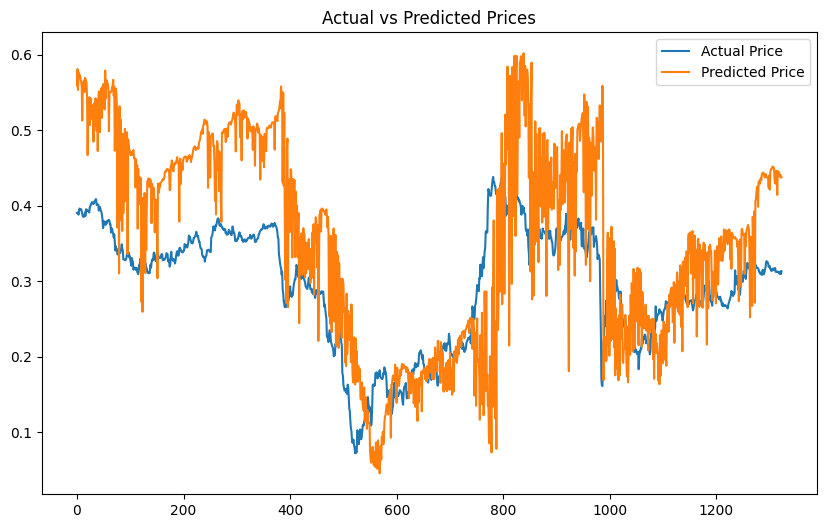

In [2]:
# Import necessary libraries
import cryptocompare
import yfinance as yf
from binance.client import Client
import pandas as pd
from datetime import datetime, timedelta
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to download data
def download_crypto_data(symbol, binance_symbol, start_date, end_date, interval, file_name):
    data = None

    # Try downloading from CryptoCompare
    try:
        print(f"Trying to download data from CryptoCompare for {symbol}...")
        all_data = []
        start_dt = datetime.strptime(start_date, '%Y-%m-%d')
        end_dt = datetime.strptime(end_date, '%Y-%m-%d')
        while start_dt < end_dt:
            next_end_dt = min(start_dt + timedelta(days=60), end_dt)
            data = cryptocompare.get_historical_price_minute(symbol, currency='USD', limit=2000, toTs=int(next_end_dt.timestamp()))
            if data:
                all_data.extend(data)
            start_dt = next_end_dt
            time.sleep(1)  # Sleep to avoid rate limit issues
        if all_data:
            data = pd.DataFrame(all_data)
            data['time'] = pd.to_datetime(data['time'], unit='s')
            data.set_index('time', inplace=True)
        print("Data downloaded from CryptoCompare.")
    except Exception as e:
        print(f"Failed to download data from CryptoCompare: {e}")

    # If CryptoCompare fails, try yfinance
    if data is None or data.empty:
        try:
            print(f"Trying to download data from Yahoo Finance for {symbol}...")
            yf_data = yf.download(symbol, start=start_date, end=end_date, interval=interval)
            if not yf_data.empty:
                yf_data.index = pd.to_datetime(yf_data.index)
                data = yf_data
            print("Data downloaded from Yahoo Finance.")
        except Exception as e:
            print(f"Failed to download data from Yahoo Finance: {e}")

    # If yfinance fails, fallback to Binance
    if data is None or data.empty:
        try:
            print(f"Trying to download data from Binance for {binance_symbol}...")
            client = Client()
            all_data = []
            start_dt = datetime.strptime(start_date, '%Y-%m-%d')
            end_dt = datetime.strptime(end_date, '%Y-%m-%d')
            while start_dt < end_dt:
                next_end_dt = min(start_dt + timedelta(days=60), end_dt)
                klines = client.get_historical_klines(binance_symbol, interval, start_dt.strftime("%d %b, %Y"), next_end_dt.strftime("%d %b, %Y"))
                if klines:
                    for kline in klines:
                        all_data.append({
                            'time': datetime.fromtimestamp(kline[0] / 1000),
                            'open': float(kline[1]),
                            'high': float(kline[2]),
                            'low': float(kline[3]),
                            'close': float(kline[4]),
                            'volume': float(kline[5])
                        })
                start_dt = next_end_dt
                time.sleep(1)  # Sleep to avoid rate limit issues
            if all_data:
                data = pd.DataFrame(all_data)
                data.set_index('time', inplace=True)
            print("Data downloaded from Binance.")
        except Exception as e:
            print(f"Failed to download data from Binance: {e}")

    if data is not None and not data.empty:
        data.to_csv(file_name)
        print(f"Data downloaded and saved to {file_name}")
    else:
        print("Failed to download data from all sources.")

# Function to preprocess data
def preprocess_data(file_name, output_file):
    # Load the data
    data = pd.read_csv(file_name)

    # Print the columns to debug
    print("Columns in the downloaded data:", data.columns)

    # Check if data is loaded properly
    if data.empty:
        raise ValueError("The data frame is empty. Please check the data download step.")

    # Rename columns if necessary
    if 'Close' in data.columns:
        data.rename(columns={'Close': 'close', 'Volume': 'volume'}, inplace=True)

    # Calculate additional features
    data['MA_10'] = data['close'].rolling(window=10).mean()
    data['MA_50'] = data['close'].rolling(window=50).mean()
    data = data.dropna()

    # Check if there are enough data points after calculating moving averages
    if data.empty:
        raise ValueError("The data frame is empty after calculating moving averages. Please check the date range and data availability.")

    # Preprocess the data
    features = ['close', 'volume', 'MA_10', 'MA_50']
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[features])
    
    # Save preprocessed data
    pd.DataFrame(scaled_data, columns=features).to_csv(output_file, index=False)
    print(f"Data preprocessed and saved to {output_file}")

# Define parameters for data acquisition and preprocessing
crypto_symbol = 'BTC-USD'
binance_symbol = 'BTCUSDT'
start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')
interval = '1m'
downloaded_file = 'crypto_data.csv'
preprocessed_file = 'preprocessed_crypto_data.csv'

# Download data
download_crypto_data(crypto_symbol, binance_symbol, start_date, end_date, interval, downloaded_file)

# Preprocess data
preprocess_data(downloaded_file, preprocessed_file)

# Load preprocessed data
data = pd.read_csv(preprocessed_file)

# Function to create sequences
def create_sequences(data, seq_length, target_shift):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_shift):
        x = data[i:i + seq_length]
        y = data[i + seq_length + target_shift][0]  # Target is the close price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
target_shift = 3  # Predict 3 intervals ahead (15 minutes ahead)
X, y = create_sequences(data.values, seq_length, target_shift)
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)  # Add dimension to match input shape

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the Transformer model class
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_layers, num_heads, hidden_size, output_size):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x

# Adjust input size to be divisible by num_heads
num_features = X.shape[2]
num_heads = 2
assert num_features % num_heads == 0, "Number of features must be divisible by the number of heads"

model = TransformerModel(num_features, num_layers=2, num_heads=num_heads, hidden_size=50, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
predicted = model(X_test).detach().cpu().numpy()
actual = y_test.cpu().numpy()

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()


In [ ]:
# # Import necessary libraries
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np
# import matplotlib.pyplot as plt
# import os
# import yfinance as yf

# # Define a function to download data if it doesn't exist
# def download_crypto_data(symbol, start_date, end_date, file_name):
#     if not os.path.exists(file_name):
#         print(f"Downloading data for {symbol} from {start_date} to {end_date}...")
#         data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
#         data.to_csv(file_name)
#         print(f"Data downloaded and saved to {file_name}")
#     else:
#         print(f"Data file {file_name} already exists. Skipping download.")

# # Parameters for data acquisition
# crypto_symbol = 'BTC-USD'
# start_date = '2018-01-01'
# end_date = '2023-12-31'
# output_file = 'crypto_data.csv'

# # Download data
# download_crypto_data(crypto_symbol, start_date, end_date, output_file)

# # Load the data
# data = pd.read_csv(output_file)

# # Calculate additional features
# data['MA_10'] = data['Close'].rolling(window=10).mean()
# data['MA_50'] = data['Close'].rolling(window=50).mean()
# data = data.dropna()

# # Preprocess the data
# features = ['Close', 'Volume', 'MA_10', 'MA_50']
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_data = scaler.fit_transform(data[features])

# # Create sequences with shifted target
# def create_sequences(data, seq_length, target_shift):
#     xs = []
#     ys = []
#     for i in range(len(data) - seq_length - target_shift):
#         x = data[i:i + seq_length]
#         y = data[i + seq_length + target_shift][0]  # Target is the close price
#         xs.append(x)
#         ys.append(y)
#     return np.array(xs), np.array(ys)

# seq_length = 50
# target_shift = 3  # Predict 3 days ahead
# X, y = create_sequences(scaled_data, seq_length, target_shift)
# X = torch.tensor(X, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32)

# # Train-test split
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# # Define the Transformer model class
# class TransformerModel(nn.Module):
#     def __init__(self, input_size, num_layers, num_heads, hidden_size, output_size):
#         super(TransformerModel, self).__init__()
#         self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size)
#         self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
#         self.fc = nn.Linear(input_size, output_size)

#     def forward(self, x):
#         x = self.transformer_encoder(x)
#         x = self.fc(x[:, -1, :])
#         return x

# # Adjust input size to be divisible by num_heads
# num_features = X.shape[2]
# num_heads = 2
# assert num_features % num_heads == 0, "Number of features must be divisible by the number of heads"

# model = TransformerModel(num_features, num_layers=2, num_heads=num_heads, hidden_size=50, output_size=1)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 100
# for epoch in range(num_epochs):
#     model.train()
#     outputs = model(X_train)
#     optimizer.zero_grad()
#     loss = criterion(outputs, y_train)
#     loss.backward()
#     optimizer.step()

#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# # Evaluate the model
# model.eval()
# predicted = model(X_test).detach().numpy()
# actual = y_test.numpy()

# # Plot the results
# plt.figure(figsize=(10,6))
# plt.plot(actual, label='Actual Price')
# plt.plot(predicted, label='Predicted Price')
# plt.title('Actual vs Predicted Prices')
# plt.legend()
# plt.show()


In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osFileNotFoundError: [Errno 2] No such file or directory: 'download_crypto_data.py'

from datetime import datetime, timedelta

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to dynamically load a script and execute it
def load_script(script_path):
    with open(script_path) as f:
        code = compile(f.read(), script_path, 'exec')
        exec(code, globals())

# Load the scripts
load_script('download_crypto_data.py')
load_script('preprocess_crypto_data.py')

# Define parameters for data acquisition and preprocessing
crypto_symbol = 'BTC-USD'
binance_symbol = 'BTCUSDT'
start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')
interval = '1m'
downloaded_file = 'crypto_data.csv'
preprocessed_file = 'preprocessed_crypto_data.csv'

# Download data
download_crypto_data(crypto_symbol, binance_symbol, start_date, end_date, interval, downloaded_file)

# Preprocess data
preprocess_data(downloaded_file, preprocessed_file)

# Load preprocessed data
data = pd.read_csv(preprocessed_file)

# Function to create sequences
def create_sequences(data, seq_length, target_shift):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_shift):
        x = data[i:i + seq_length]
        y = data[i + seq_length + target_shift][0]  # Target is the close price
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 50
target_shift = 3  # Predict 3 intervals ahead (15 minutes ahead)
X, y = create_sequences(data.values, seq_length, target_shift)
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)  # Add dimension to match input shape

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the Transformer model class
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_layers, num_heads, hidden_size, output_size):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_size, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])
        return x

# Adjust input size to be divisible by num_heads
num_features = X.shape[2]
num_heads = 2
assert num_features % num_heads == 0, "Number of features must be divisible by the number of heads"

model = TransformerModel(num_features, num_layers=2, num_heads=num_heads, hidden_size=50, output_size=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
predicted = model(X_test).detach().cpu().numpy()
actual = y_test.cpu().numpy()

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(actual, label='Actual Price')
plt.plot(predicted, label='Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()
